In [1]:
# http://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-scratch.html

from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon

/usr/local/lib/python3.6/site-packages/mxnet/optimizer.py:136: UserWarning: WARNING: New optimizer mxnet.optimizer.NAG is overriding existing optimizer mxnet.optimizer.NAG
  Optimizer.opt_registry[name].__name__))


In [2]:

data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [3]:
# Load mnist data
num_inputs = 784
num_outputs = 10
batch_size = 64
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

In [4]:
# Allocate Params
# http://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-scratch.html#Allocate-parameters
#######################
#  Set some constants so it's easy to modify the network later
#######################
num_hidden = 256
weight_scale = .01

#######################
#  Allocate parameters for the first hidden layer
#######################
W1 = nd.random_normal(shape=(num_inputs, num_hidden), scale=weight_scale, ctx=model_ctx)
b1 = nd.random_normal(shape=num_hidden, scale=weight_scale, ctx=model_ctx)

#######################
#  Allocate parameters for the second hidden layer
#######################
W2 = nd.random_normal(shape=(num_hidden, num_hidden), scale=weight_scale, ctx=model_ctx)
b2 = nd.random_normal(shape=num_hidden, scale=weight_scale, ctx=model_ctx)

#######################
#  Allocate parameters for the output layer
#######################
W3 = nd.random_normal(shape=(num_hidden, num_outputs), scale=weight_scale, ctx=model_ctx)
b3 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=model_ctx)

params = [W1, b1, W2, b2, W3, b3]

In [5]:
# allocate spece for params gradients
for param in params:
    param.attach_grad()

In [6]:
# Activation functions
# http://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-scratch.html#Activation-functions
# rectified linear unit (ReLU):
def relu(X):
    return nd.maximum(X, nd.zeros_like(X))

In [7]:
# typical softmax and cross entropy
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear))
    partition = nd.nansum(exp, axis=0, exclude=True).reshape((-1, 1))
    return exp / partition

# improvement on old cross_entropy
# http://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-scratch.html#The-softmax-cross-entropy-loss-function
def softmax_cross_entropy(yhat_linear, y):
    return - nd.nansum(y * nd.log_softmax(yhat_linear), axis=0, exclude=True)

# old c e function
# def cross_entropy(yhat, y):
#     return - nd.nansum(y * nd.log(yhat), axis=0, exclude=True)

In [8]:
# all 3 layers stacked up
def net(X):
    #######################
    #  Compute the first hidden layer
    #######################
    h1_linear = nd.dot(X, W1) + b1
    h1 = relu(h1_linear)

    #######################
    #  Compute the second hidden layer
    #######################
    h2_linear = nd.dot(h1, W2) + b2
    h2 = relu(h2_linear)

    #######################
    #  Compute the output layer.
    #  We will omit the softmax function here
    #  because it will be applied
    #  in the softmax_cross_entropy loss
    #######################
    yhat_linear = nd.dot(h2, W3) + b3
    return yhat_linear

In [9]:
# optimizer
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad
        

In [10]:
# Evaluation
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [11]:
# Training loop
epochs = 10
learning_rate = .001
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 1.23557546169, Train_acc 0.883183, Test_acc 0.8822
Epoch 1. Loss: 0.334782772899, Train_acc 0.921267, Test_acc 0.9207
Epoch 2. Loss: 0.227777026486, Train_acc 0.946833, Test_acc 0.9455
Epoch 3. Loss: 0.165289376726, Train_acc 0.960917, Test_acc 0.9568
Epoch 4. Loss: 0.128114886862, Train_acc 0.9655, Test_acc 0.9599
Epoch 5. Loss: 0.104161829895, Train_acc 0.97535, Test_acc 0.9674
Epoch 6. Loss: 0.0873585311055, Train_acc 0.97565, Test_acc 0.9677
Epoch 7. Loss: 0.0751715123077, Train_acc 0.9802, Test_acc 0.9718
Epoch 8. Loss: 0.064577267994, Train_acc 0.985067, Test_acc 0.973
Epoch 9. Loss: 0.05684501602, Train_acc 0.98665, Test_acc 0.9742


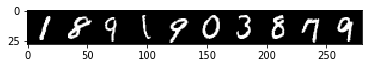

model predictions are: 
[ 1.  8.  9.  1.  9.  0.  3.  8.  7.  9.]
<NDArray 10 @cpu(0)>
true labels : 
[ 1.  8.  9.  1.  9.  0.  3.  8.  7.  9.]
<NDArray 10 @cpu(0)>


In [17]:
# Using model for prediction
import matplotlib.pyplot as plt
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

samples = 10

# let's sample 10 random data points from the test set
#sample_data = mx.gluon.data.DataLoader(mnist_test, samples, shuffle=True)
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              samples, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    print('true labels :', label)
    break